In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Set the path to the directory containing the image folders
data_path = "Images/"

# Define the transforms to be applied to each image
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Load the dataset using the ImageFolder class
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Define the proportions for the training, validation, and test sets
train_prop = 0.8
val_prop = 0.1
test_prop = 0.1

# Compute the sizes of each set
num_data = len(dataset)
num_train = int(train_prop * num_data)
num_val = int(val_prop * num_data)
num_test = num_data - num_train - num_val

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [num_train, num_val, num_test])

# Define the data loaders for the training, validation, and test sets
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


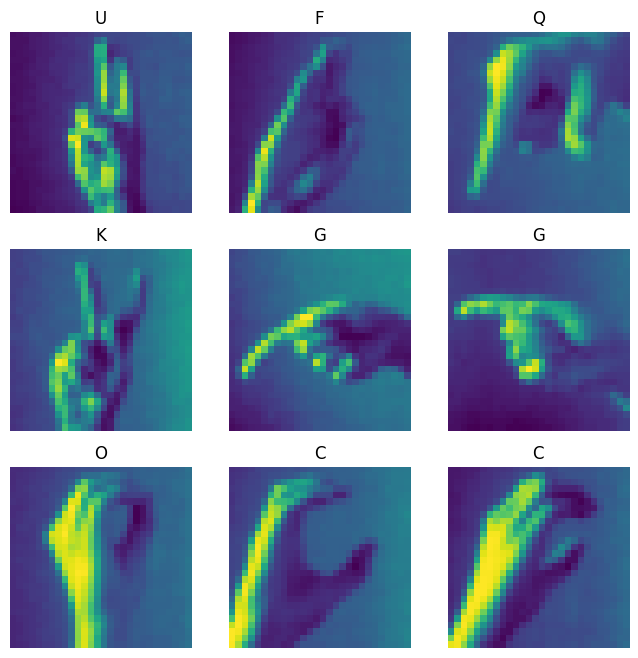

In [2]:
import torch
import matplotlib.pyplot as plt

alphabet_dict = {0: 'A',1: 'B',2: 'C',3: 'D',4: 'E',5: 'F',6: 'G',7: 'H',8: 'I',9: 'K',10: 'L',11: 'M',
    12: 'N',13: 'O',14: 'P',15: 'Q',16: 'R',17: 'S',18: 'T',19: 'U',20: 'V',21: 'W',22: 'X',23: 'Y'}

figure = plt.figure(figsize=(8, 8)) #defining the figure size
cols, rows = 3, 3 #numbers of rows and colomns

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item() #taking a random sample from the training data
    img, label = dataset[sample_idx] #saving the img and label of that sample
    figure.add_subplot(rows, cols, i) #adding the subplot at the right position
    plt.title(str(alphabet_dict[label])) #printing the lable (class) of the image
    plt.axis("off") #switching the axis off for a better result
    plt.imshow(img.squeeze()) #visulizing the tensor as an image
plt.show()

In [3]:
import torch
import torch.nn as nn

device = "cuda" if torch.has_cuda else "cpu"

class CNN_Classification_Net(nn.Module):
    def __init__(self, num_classes, input_shape) -> None:
        super(CNN_Classification_Net,self).__init__()

        # first convolution layer + activation + max pooling (first layer it to capture the edges)
        self.conv1 = nn.Conv2d(in_channels = input_shape[0], out_channels = 20,
                                kernel_size=(5, 5)) #Resulting tensor size (20,24,24)
        self.act1 = nn.ReLU()#Keeping in mind that both ReLU and Pooling are doing the same thing (max(f(x),f(x2)) = f(max(x1,x2))) so the order doesn't matter.
        self.pool1 = nn.MaxPool2d(kernel_size= 2) #Resulting tensor size (20,12,12)
        self.bn1 = nn.BatchNorm2d(num_features = 20) #Batch normalization

        # second convolution layer + activation + max pooling (Second layer is for blobs and sphirical shapes)
        self.conv2 = nn.Conv2d(in_channels = 20, out_channels = 50, 
                                kernel_size = (5, 5)) #Resulting tensor (50,8,8)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 2) #Resulting tensor (50,4,4)
        self.bn2 = nn.BatchNorm2d(num_features = 50) #Batch normalization

        # second convolution layer + activation + max pooling (Second layer is for blobs and sphirical shapes)
        self.conv3 = nn.Conv2d(in_channels = 50, out_channels = 100, 
                                kernel_size = (3, 3)) #Resulting tensor (100,2,2)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size = 2) #Resulting tensor (100,1,1)
        self.bn3 = nn.BatchNorm2d(num_features = 100) #Batch normalization

        # first linear layer + activation
        self.conv_output_len = (100*1*1)
        self.linear1 = nn.Linear(in_features = self.conv_output_len, out_features = 240) 
        self.act4 = nn.ReLU()

        # dropout between the linear layers
        self.drop = nn.Dropout(p=0.3)
        
        # second linear layer + activation
        self.linear2 = nn.Linear(in_features = 240, out_features = 120)
        self.act5 = nn.ReLU()

        # dropout between the linear layers
        self.drop = nn.Dropout(p=0.3)

        # third linear layer + activation
        self.linear3 = nn.Linear(in_features = 120, out_features = 60)
        self.act6 = nn.ReLU()

        # final linear layer to produce the correct number of outputs
        self.out = nn.Linear(in_features = 60, out_features = num_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # perform convolution -> activation -> pooling
        x = self.bn1(self.pool1(self.act1(self.conv1(x))))
        x = self.bn2(self.pool2(self.act2(self.conv2(x))))
        x = self.bn3(self.pool3(self.act3(self.conv3(x))))

        # flatten the features obtained from the conv layers: (BATCH_SIZE, 50, 4, 4) -> (BATCH_SIZE, 50*4*4=800)
        batch_size = x.shape[0]
        x = x.view(batch_size, self.conv_output_len)

        # final linear layers and activations
        x = self.act4(self.linear1(x))
        x = self.act5(self.linear2(x))
        x = self.act6(self.linear3(x))
        x = self.out(x)

        return x

CNN_Model = CNN_Classification_Net(24,(1,28,28)).to(device)
print(CNN_Model)

CNN_Classification_Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=100, out_features=240, bias=True)
  (act4): ReLU()
  (drop): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=240, out_features=120, bias=True)
  (act5): ReLU()
  (linear3

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor,RandomPerspective,RandomRotation

#Implementing both training and testing sets
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        #Putting both tensors on the GPU
        X=X.to(device)
        y=y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        avg_loss += loss.detach().cpu().numpy().item()

        # Backpropagation
        optimizer.zero_grad()#reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
        loss.backward()#Backpropagate the prediction loss
        optimizer.step()#adjust the parameters by the gradients collected in the backward pass.

        if batch % 300 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss /= num_batches
    train_losses.append(avg_loss)


def val_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X=X.to(device)
            y=y.to(device)
            pred = model(X) 
            val_loss += loss_fn(pred, y).detach().cpu().numpy().item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    val_losses.append(val_loss)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

#Defining the Training Parameters
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(CNN_Model.parameters(),lr = 0.001,weight_decay = 0.001)
epochs = 3

#Starting the training and testing
train_losses = []
val_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, CNN_Model, loss_fn,optimizer)
    val_loop(val_loader, CNN_Model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.155305  [    0/19200]
loss: 0.056001  [ 2400/19200]
loss: 0.318514  [ 4800/19200]
loss: 0.037689  [ 7200/19200]
loss: 0.013060  [ 9600/19200]
loss: 0.322616  [12000/19200]
loss: 0.034918  [14400/19200]
loss: 0.002865  [16800/19200]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.011802 

Epoch 2
-------------------------------
loss: 0.061216  [    0/19200]
loss: 0.002647  [ 2400/19200]
loss: 0.003115  [ 4800/19200]
loss: 0.010920  [ 7200/19200]
loss: 0.000121  [ 9600/19200]
loss: 0.002026  [12000/19200]
loss: 0.000795  [14400/19200]
loss: 0.007764  [16800/19200]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.006515 

Epoch 3
-------------------------------
loss: 0.000478  [    0/19200]
loss: 0.015046  [ 2400/19200]
loss: 0.003008  [ 4800/19200]
loss: 0.004945  [ 7200/19200]
loss: 0.000530  [ 9600/19200]
loss: 0.000006  [12000/19200]
loss: 0.000294  [14400/19200]
loss: 0.040295  [16800/19200]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000669 

Don

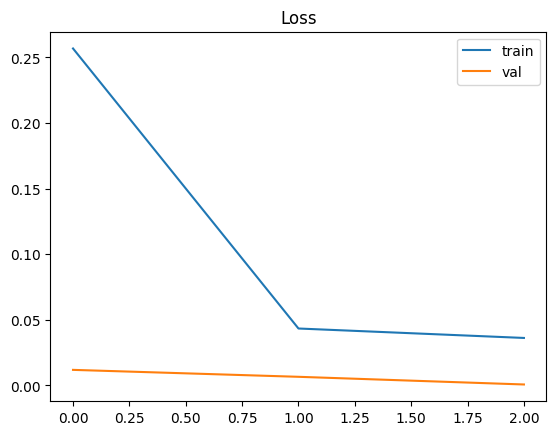

In [46]:
import matplotlib.pyplot as plt

plt.title("Loss")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

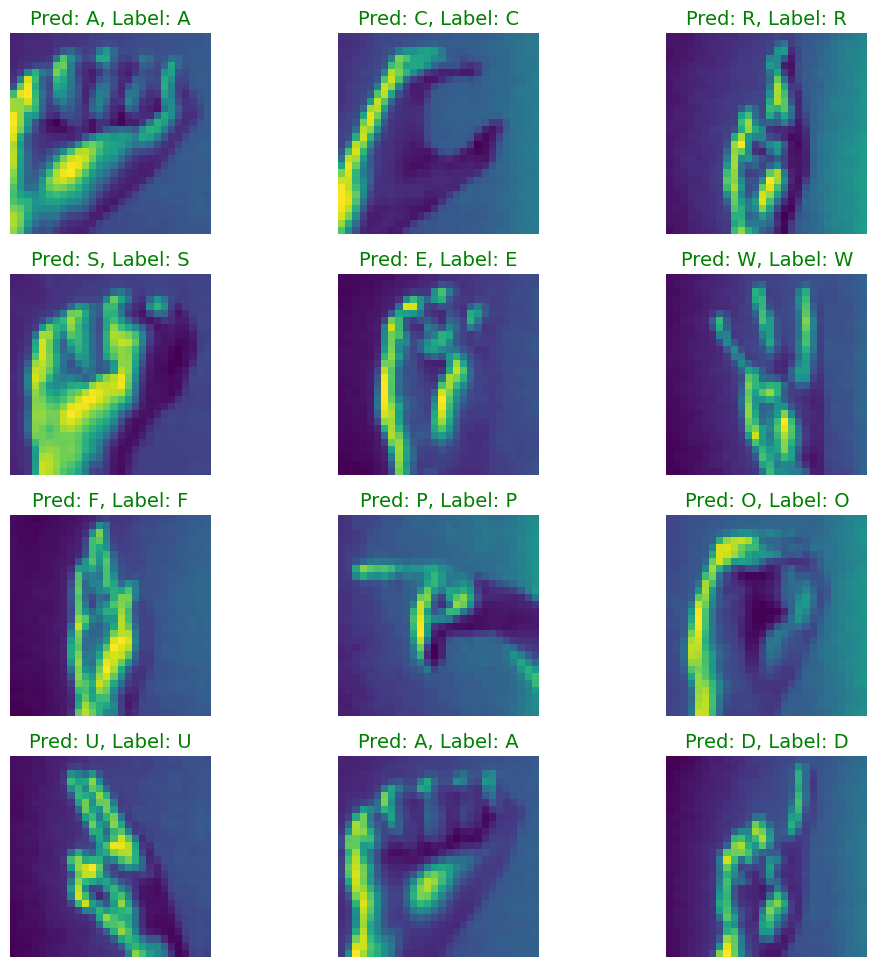

In [47]:
import torch
import matplotlib.pyplot as plt

alphabet_dict = {0: 'A',1: 'B',2: 'C',3: 'D',4: 'E',5: 'F',6: 'G',7: 'H',8: 'I',9: 'K',10: 'L',11: 'M',
    12: 'N',13: 'O',14: 'P',15: 'Q',16: 'R',17: 'S',18: 'T',19: 'U',20: 'V',21: 'W',22: 'X',23: 'Y'}

figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item() #Generating a random number from the dataset
    img, label = test_dataset[sample_idx]
    img, label = img, label #Moving img Tensor to GPU to load it on the network
    pred = CNN_Model(img[None, ...]).argmax(1) #I've extended the tensor because the network expect a tensor of size 4 ([number of images, Channel, Width, Hight]) and the image sample would only have the last 3

    figure.add_subplot(rows, cols, i)
    plt.title(f"Pred: {str(alphabet_dict[pred.item()])}, Label: {str(alphabet_dict[label])}", fontdict={"fontsize": 14, "color": ("green" if str(pred.item()) == str(label) else "red")})
    plt.axis("off")
    plt.imshow(img.cpu().squeeze()) #Had to move the tensor to the cpu before squeezing it to visualize it.

plt.show()

In [51]:

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
from tqdm import tqdm

alphabet_dict = {0: 'A',1: 'B',2: 'C',3: 'D',4: 'E',5: 'F',6: 'G',7: 'H',8: 'I',9: 'K',10: 'L',11: 'M',
    12: 'N',13: 'O',14: 'P',15: 'Q',16: 'R',17: 'S',18: 'T',19: 'U',20: 'V',21: 'W',22: 'X',23: 'Y'}

y_pred = []
y_true = []
wrong_preds = []

CNN_Model.to("cpu")

# iterate over test data
for img, label in tqdm(test_dataset):
        output =CNN_Model(img[None, ...]).argmax(1)
        y_pred.append(output.item()) # Save Prediction
        y_true.append(label) # Save Truth
        if label != output:
            wrong_preds.append((img,label))

# images that the model predicted wrong
print(f"Out of {len(test_dataset)} images the model has predicted {len(wrong_preds)} wrong images")

# visualize the mistakes if they exist
if len(wrong_preds)>0:
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10) #instead of numbers to get a precentage
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

    # Visualizing random images that the model predicted wrong
    figure = plt.figure(figsize=(12, 12))
    cols, rows = 3, 4

    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(wrong_preds), size=(1,)).item() 
        img, label = wrong_preds[sample_idx]

        pred = CNN_Model(img[None, ...]).argmax(1)

        figure.add_subplot(rows, cols, i)
        plt.title(f"Pred: {str(alphabet_dict[pred.item()])}, Label: {str(alphabet_dict[label])}", fontdict={"fontsize": 14, "color": ("green" if str(pred.item()) == str(label) else "red")})
        plt.axis("off")
        plt.imshow(img.cpu().squeeze()) 

    plt.show()

100%|██████████| 2400/2400 [00:15<00:00, 153.19it/s]

Out of 2400 images the model has predicted 0 wrong images


In [52]:
import torch
import os

CNN_Model = CNN_Model.to('cpu') #Loading the model back to cpu to avoid Problems
CNN_Model.eval()

dummy_input = torch.randn(1,1,28,28) #Saving a dummy input since it's required for Onnx Format where as the first elem. is the patch size
input_names = [ "actual_input" ] 
output_names = [ "output" ]

model_path = "Models/"
os.makedirs(model_path,exist_ok=True) #Create the file if the file doesn't exist

torch.onnx.export(CNN_Model, 
                dummy_input,
                model_path + "CNN_Model_Sign_Language_best.onnx",
                input_names=input_names,
                output_names=output_names,
                opset_version = 11,
                export_params=True,
                )

============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



c:\Users\VIRGA\anaconda3\envs\test\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:54: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


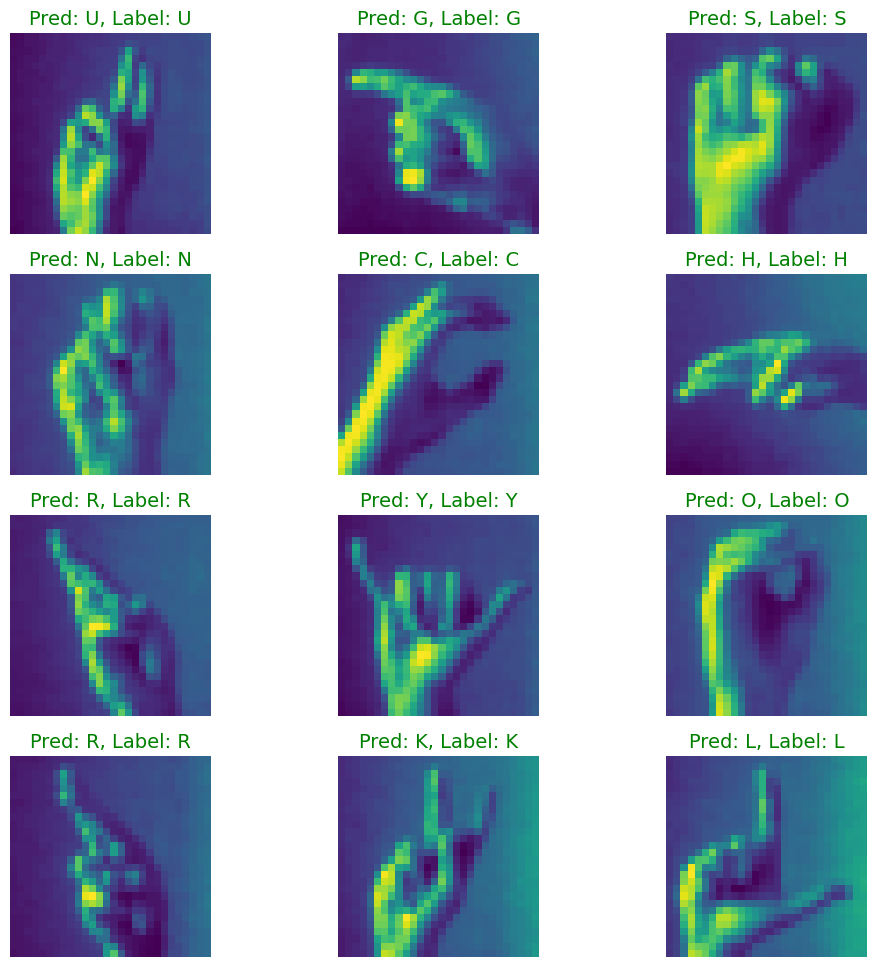

In [4]:
import onnx, onnxruntime
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

alphabet_dict = {0: 'A',1: 'B',2: 'C',3: 'D',4: 'E',5: 'F',6: 'G',7: 'H',8: 'I',9: 'K',10: 'L',11: 'M',
    12: 'N',13: 'O',14: 'P',15: 'Q',16: 'R',17: 'S',18: 'T',19: 'U',20: 'V',21: 'W',22: 'X',23: 'Y'}

model_path = 'Models/CNN_Model_Sign_Language_best.onnx'
onnx_model = onnx.load(model_path)
onnx.checker.check_model(onnx_model)

#to preprocess an external image
resize = transforms.Compose(
                [ transforms.Resize((28,28)),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor()])        

EP_list = ['CUDAExecutionProvider', 'CPUExecutionProvider']

ort_session = onnxruntime.InferenceSession(model_path, providers=EP_list)

def to_numpy(x):
    return x.detach().cpu().numpy() if x.requires_grad else x.cpu().numpy()

# compute ONNX Runtime output prediction
def predict_class(img):
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img)}
    ort_outs = ort_session.run(None, ort_inputs)
    pred = list(ort_outs[0][0]).index(max(ort_outs[0][0]))

    return pred

figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item() 
    img, label = test_dataset[sample_idx]
    pred = predict_class(img[None, ...])

    figure.add_subplot(rows, cols, i)
    plt.title(f"Pred: {str(alphabet_dict[pred])}, Label: {str(alphabet_dict[label])}", fontdict={"fontsize": 14, "color": ("green" if str(pred) == str(label) else "red")})
    plt.axis("off")
    plt.imshow(img.cpu().squeeze()) 

plt.show()